In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from pytorch_tabnet.tab_model import TabNetClassifier

import tensorflow as tf
import torch
import keras
# Model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.initializers import RandomNormal, Constant

# Metrics
from sklearn.metrics import roc_auc_score, average_precision_score, balanced_accuracy_score
from sklearn.metrics import make_scorer

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, QuantileTransformer, RobustScaler, StandardScaler,MinMaxScaler
from tensorflow.keras.optimizers  import Adam, Adagrad, SGD, RMSprop

from sklearn.metrics import confusion_matrix, roc_curve
from sklearn.model_selection import train_test_split 

import fairness_helpers as fh
import utilities
import global_variables as gv

import shap

#### load data

In [2]:
df = pd.read_csv('data/binary_full.csv')
pd.set_option('display.max_columns', None)
df.drop('Unnamed: 0', axis=1, inplace=True)

#### retreive model

In [3]:
model = keras.models.load_model('saved_models/mlp_binary_1.h5')
model.compile(loss='binary_crossentropy', #categorical_hinge
              optimizer=SGD(learning_rate=0.0005),
              metrics=['acc',tf.keras.metrics.AUC(), tf.keras.metrics.Recall()])

#### split data and predict probabilities on test dataset

In [56]:
X_train, X_val,  X_test, y_train, y_val, y_test = utilities.process_features(df, 'CVD', RobustScaler(), one_hot=True, val=True, test_size=0.3)

# y_prob = model.predict(X_test) # outputs probablity assigned to Class 1
# y_prob

In [5]:
one_count=0
zero_count=0
one_total=0
zero_total=0
for i, val in zip(y_test, y_prob):
    if i == 1:
        one_count+=1
        one_total+=val
    elif i==0:
        zero_count+=1
        zero_total+=val

print(one_total/one_count)
print(zero_total/zero_count)

[0.5731583]
[0.42829001]


#### some functions to evaluate model predictions

In [6]:
def confusion_eval(model, X_test, y_test, threshold=0.5):
    """
    Takes in model, testing data, and decision threshold and outputs prediction performance (confusion matrix,
    sensitivity, specificity, and accuracy)
    """
    y_predicted = (model.predict(X_test) >= threshold)

    conf_mat = confusion_matrix(y_test, y_predicted)
    print(conf_mat)
    total = sum(sum(conf_mat))
    sensitivity = conf_mat[0, 0]/(conf_mat[0, 0] + conf_mat[1, 0])
    specificity = conf_mat[1, 1]/(conf_mat[1, 1] + conf_mat[0, 1])
    accuracy = (conf_mat[0, 0] + conf_mat[1, 1])/total
    bal_accuracy = balanced_accuracy_score(y_test, y_predicted)
    print('specificity : ', specificity)
    print('sensitivity : ', sensitivity)
    print('accuracy : ', accuracy)
    print('balanced accuracy: ', bal_accuracy)
    return conf_mat, sensitivity, specificity, accuracy, bal_accuracy

In [32]:
def confusion_eval2(predictions, X_test, y_test, threshold=0.5):
    """
    Takes in model, testing data, and decision threshold and outputs prediction performance (confusion matrix,
    sensitivity, specificity, and accuracy)
    """
    y_predicted = (predictions >= threshold)

    conf_mat = confusion_matrix(y_test, y_predicted)
    print(conf_mat)
    total = sum(sum(conf_mat))
    sensitivity = conf_mat[0, 0]/(conf_mat[0, 0] + conf_mat[1, 0])
    specificity = conf_mat[1, 1]/(conf_mat[1, 1] + conf_mat[0, 1])
    accuracy = (conf_mat[0, 0] + conf_mat[1, 1])/total
    bal_accuracy = balanced_accuracy_score(y_test, y_predicted)
    print('specificity : ', specificity)
    print('sensitivity : ', sensitivity)
    print('accuracy : ', accuracy)
    print('balanced accuracy: ', bal_accuracy)
    return conf_mat, sensitivity, specificity, accuracy, bal_accuracy

### let's figure out the best threshold to minimize false negatives!

> Since this problem is a case of medical diagnostics, we care way more about correctly diagnosing the people who actually have CVDs so that they can get treatment, therefore we are willing to allow a few more false positive cases to ensure the best ultimate health outcomes for everyone. (focus on maximizing Sensitivity)

#### optimal threshold for ROC Curve

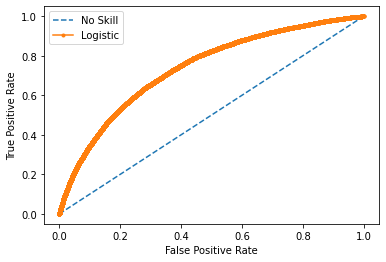

In [7]:
# calculate scores
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()

In [48]:
y_prob = model.predict(X_test)
test_thresholds=np.arange(0,1,0.01)
df_results = pd.DataFrame(columns = ['threshold', 'specificity', 'sensitivity', 'accuracy', 'balanced accuracy'])
for threshold in test_thresholds:
    mat, sens,spec, acc, bal = confusion_eval2(y_prob, X_test, y_test, threshold=threshold)
    
    df_new = pd.DataFrame({'threshold':threshold, 'specificity':spec, 'sensitivity':sens, 'accuracy':acc, 'balanced accuracy':bal}, index=[0])
    df_results = pd.concat([df_results,df_new])

4711/4711 [==============================] - 32s 7ms/step
[[     0 136668]
 [     0  14077]]
specificity :  0.09338286510332018
sensitivity :  nan
accuracy :  0.09338286510332018
balanced accuracy:  0.5
[[     0 136668]
 [     0  14077]]
specificity :  0.09338286510332018
sensitivity :  nan
accuracy :  0.09338286510332018
balanced accuracy:  0.5
[[     0 136668]
 [     0  14077]]
specificity :  0.09338286510332018
sensitivity :  nan
accuracy :  0.09338286510332018
balanced accuracy:  0.5


invalid value encountered in longlong_scalars
invalid value encountered in longlong_scalars
invalid value encountered in longlong_scalars


[[     0 136668]
 [     0  14077]]
specificity :  0.09338286510332018
sensitivity :  nan
accuracy :  0.09338286510332018
balanced accuracy:  0.5
[[     0 136668]
 [     0  14077]]
specificity :  0.09338286510332018
sensitivity :  nan
accuracy :  0.09338286510332018
balanced accuracy:  0.5
[[     0 136668]
 [     0  14077]]
specificity :  0.09338286510332018
sensitivity :  nan
accuracy :  0.09338286510332018
balanced accuracy:  0.5


invalid value encountered in longlong_scalars
invalid value encountered in longlong_scalars
invalid value encountered in longlong_scalars


[[     0 136668]
 [     0  14077]]
specificity :  0.09338286510332018
sensitivity :  nan
accuracy :  0.09338286510332018
balanced accuracy:  0.5
[[     0 136668]
 [     0  14077]]
specificity :  0.09338286510332018
sensitivity :  nan
accuracy :  0.09338286510332018
balanced accuracy:  0.5
[[     0 136668]
 [     0  14077]]


invalid value encountered in longlong_scalars
invalid value encountered in longlong_scalars
invalid value encountered in longlong_scalars


specificity :  0.09338286510332018
sensitivity :  nan
accuracy :  0.09338286510332018
balanced accuracy:  0.5
[[     2 136666]
 [     0  14077]]
specificity :  0.09338410407116748
sensitivity :  1.0
accuracy :  0.0933961325417095
balanced accuracy:  0.5000073170017854
[[    14 136654]
 [     0  14077]]
specificity :  0.0933915385687085
sensitivity :  1.0
accuracy :  0.0934757371720455
balanced accuracy:  0.5000512190124975
[[    38 136630]
 [     1  14076]]
specificity :  0.09340039547197855
sensitivity :  0.9743589743589743
accuracy :  0.09362831271352284
balanced accuracy:  0.5001035041023311
[[   131 136537]
 [     2  14075]]
specificity :  0.09345204897352137
sensitivity :  0.9849624060150376
accuracy :  0.09423861487943215
balanced accuracy:  0.5004082257537592
[[   343 136325]
 [     5  14072]]
specificity :  0.0935656961242578
sensitivity :  0.985632183908046
accuracy :  0.09562506219111745
balanced accuracy:  0.5010772711482345
[[   710 135958]
 [    15  14062]]
specificity :  

specificity :  0.21382078853046596
sensitivity :  0.9428670061275567
accuracy :  0.7742014660519421
balanced accuracy:  0.6645558953952984
[[111167  25501]
 [  6915   7162]]
specificity :  0.21926950984294155
sensitivity :  0.9414390000169374
accuracy :  0.784961358585691
balanced accuracy:  0.6610911567873462
[[113093  23575]
 [  7228   6849]]
specificity :  0.22511832763607678
sensitivity :  0.9399273609760557
accuracy :  0.7956615476466881
balanced accuracy:  0.6570200039187983
[[114967  21701]
 [  7551   6526]]
specificity :  0.23119708080915435
sensitivity :  0.9383682397688503
accuracy :  0.8059504461176158
balanced accuracy:  0.6524034196879263
[[116715  19953]
 [  7875   6202]]
specificity :  0.2371248327279679
sensitivity :  0.9367926799903684
accuracy :  0.815396862250821
balanced accuracy:  0.6472903454129865
[[118443  18225]
 [  8243   5834]]
specificity :  0.24248721892015462
sensitivity :  0.9349336153955449
accuracy :  0.8244187203555674
balanced accuracy:  0.64054126813

invalid value encountered in longlong_scalars
invalid value encountered in longlong_scalars
invalid value encountered in longlong_scalars


specificity :  nan
sensitivity :  0.9066171348966798
accuracy :  0.9066171348966798
balanced accuracy:  0.5
[[136668      0]
 [ 14077      0]]
specificity :  nan
sensitivity :  0.9066171348966798
accuracy :  0.9066171348966798
balanced accuracy:  0.5
[[136668      0]
 [ 14077      0]]
specificity :  nan
sensitivity :  0.9066171348966798
accuracy :  0.9066171348966798
balanced accuracy:  0.5
[[136668      0]
 [ 14077      0]]


invalid value encountered in longlong_scalars
invalid value encountered in longlong_scalars
invalid value encountered in longlong_scalars
invalid value encountered in longlong_scalars


specificity :  nan
sensitivity :  0.9066171348966798
accuracy :  0.9066171348966798
balanced accuracy:  0.5
[[136668      0]
 [ 14077      0]]
specificity :  nan
sensitivity :  0.9066171348966798
accuracy :  0.9066171348966798
balanced accuracy:  0.5
[[136668      0]
 [ 14077      0]]
specificity :  nan
sensitivity :  0.9066171348966798
accuracy :  0.9066171348966798
balanced accuracy:  0.5


invalid value encountered in longlong_scalars


In [ ]:
df_results

#### plot threshold results

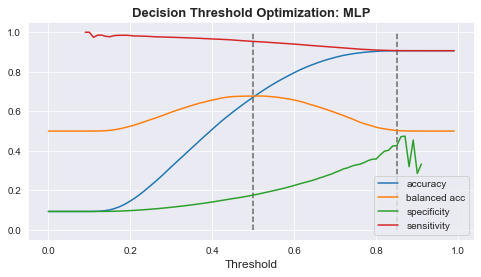

In [51]:
sns.set_style("darkgrid")

# plot lines
plt.figure(figsize=(8,4))
plt.plot(df_results['threshold'], df_results['accuracy'], label = "accuracy")
plt.plot(df_results['threshold'], df_results['balanced accuracy'], label = "balanced acc")
plt.plot(df_results['threshold'], df_results['specificity'], label = "specificity")
plt.plot(df_results['threshold'], df_results['sensitivity'], label = "sensitivity")
# single line
plt.vlines(x = 0.5, ymin = 0, ymax = 1.0,
           colors = 'dimgray',
           linestyle='--')
plt.vlines(x = 0.85, ymin = 0, ymax = 1.0,
           colors = 'dimgray',
           linestyle='--')
# plt.legend(loc='upper left')
plt.legend(loc='lower right')
plt.title('Decision Threshold Optimization: MLP', fontsize=13, fontweight='bold')
plt.xlabel('Threshold', fontsize=12)
plt.savefig('charts/models/MLP/mlp_threshold_balanced.png', bbox_inches='tight')
plt.show()

#### build SHAP explainer

In [ ]:
explainer = shap.KernelExplainer(model.predict,X_train)

## XGBoost Model

In [22]:
model_xgb = xgb.Booster()
model_xgb.load_model("saved_models/boost_1.json")

In [30]:
from xgboost import XGBClassifier

n_estimators = 1000

clf_xgb = XGBClassifier(max_depth=8,
    learning_rate=0.01,
    n_estimators=n_estimators,
    verbosity=0,
    silent=None,
    objective="binary:logistic",
    booster='gbtree',
    n_jobs=-1,
    nthread=None,
    gamma=0,
    min_child_weight=1,
    max_delta_step=0,
    subsample=0.7,
    colsample_bytree=1,
    colsample_bylevel=1,
    colsample_bynode=1,
    reg_alpha=0,
    reg_lambda=1,
    scale_pos_weight=1,
    base_score=0.5,
    random_state=0,
    seed=None,)

clf_xgb.fit(X_train, y_train,
            eval_set=[(X_val, y_val)],
            early_stopping_rounds=40,
            verbose=20)

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


[0]	validation_0-logloss:0.68621
[20]	validation_0-logloss:0.57213
[40]	validation_0-logloss:0.49216
[60]	validation_0-logloss:0.43436
[80]	validation_0-logloss:0.39187
[100]	validation_0-logloss:0.36026
[120]	validation_0-logloss:0.33659
[140]	validation_0-logloss:0.31880
[160]	validation_0-logloss:0.30542
[180]	validation_0-logloss:0.29534
[200]	validation_0-logloss:0.28776
[220]	validation_0-logloss:0.28210
[240]	validation_0-logloss:0.27787
[260]	validation_0-logloss:0.27471
[280]	validation_0-logloss:0.27235
[300]	validation_0-logloss:0.27063
[320]	validation_0-logloss:0.26935
[340]	validation_0-logloss:0.26840
[360]	validation_0-logloss:0.26769
[380]	validation_0-logloss:0.26718
[400]	validation_0-logloss:0.26681
[420]	validation_0-logloss:0.26654
[440]	validation_0-logloss:0.26632
[460]	validation_0-logloss:0.26612
[480]	validation_0-logloss:0.26599
[500]	validation_0-logloss:0.26587
[520]	validation_0-logloss:0.26573
[540]	validation_0-logloss:0.26565
[560]	validation_0-logloss

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=8, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=1000,
              n_jobs=-1, nthread=-1, num_parallel_tree=1, predictor='auto',
              random_state=0, reg_alpha=0, ...)

In [31]:
y_boost_pred = clf_xgb.predict_proba(X_test)[:,1]

In [44]:
test_thresholds=np.arange(0,1,0.02)
df_results2 = pd.DataFrame(columns = ['threshold', 'specificity', 'sensitivity', 'accuracy', 'balanced accuracy'])
for threshold in test_thresholds:
    mat, sens,spec, acc, bal = confusion_eval2(y_boost_pred, X_test, y_test, threshold=threshold)
    
    df_new = pd.DataFrame({'threshold':threshold, 'specificity':spec, 'sensitivity':sens, 'accuracy':acc, 'balanced accuracy':bal}, index=[0])
    df_results2 = pd.concat([df_results2,df_new])

[[     0 136668]
 [     0  14077]]
specificity :  0.09338286510332018
sensitivity :  nan
accuracy :  0.09338286510332018
balanced accuracy:  0.5
[[ 16103 120565]
 [   282  13795]]
specificity :  0.10267192616850253
sensitivity :  0.9827891364052487
accuracy :  0.1983349364821387
balanced accuracy:  0.5488965011662013
[[55042 81626]
 [ 1503 12574]]


invalid value encountered in longlong_scalars


specificity :  0.13348195329087048
sensitivity :  0.9734194004774958
accuracy :  0.44854555706656934
balanced accuracy:  0.6479862519539961
[[76833 59835]
 [ 2701 11376]]
specificity :  0.15975060032860092
sensitivity :  0.9660396811426559
accuracy :  0.5851537364423364
balanced accuracy:  0.6851569648607957
[[91267 45401]
 [ 3845 10232]]
specificity :  0.18391961605521903
sensitivity :  0.9595739759441501
accuracy :  0.673315864539454
balanced accuracy:  0.6973301090060802
[[101170  35498]
 [  4868   9209]]
specificity :  0.2059856398326884
sensitivity :  0.9540919293083612
accuracy :  0.7322232909880925
balanced accuracy:  0.6972243763291128
[[108215  28453]
 [  5797   8280]]
specificity :  0.2254103939237198
sensitivity :  0.9491544749675472
accuracy :  0.7727951175826727
balanced accuracy:  0.6900014276703932
[[113643  23025]
 [  6659   7418]]
specificity :  0.24366849522057615
sensitivity :  0.9446476367807684
accuracy :  0.8030846794255199
balanced accuracy:  0.6792424514847852
[

invalid value encountered in longlong_scalars
invalid value encountered in longlong_scalars
invalid value encountered in longlong_scalars


specificity :  nan
sensitivity :  0.9066171348966798
accuracy :  0.9066171348966798
balanced accuracy:  0.5
[[136668      0]
 [ 14077      0]]
specificity :  nan
sensitivity :  0.9066171348966798
accuracy :  0.9066171348966798
balanced accuracy:  0.5
[[136668      0]
 [ 14077      0]]
specificity :  nan
sensitivity :  0.9066171348966798
accuracy :  0.9066171348966798
balanced accuracy:  0.5


invalid value encountered in longlong_scalars
invalid value encountered in longlong_scalars
invalid value encountered in longlong_scalars


[[136668      0]
 [ 14077      0]]
specificity :  nan
sensitivity :  0.9066171348966798
accuracy :  0.9066171348966798
balanced accuracy:  0.5
[[136668      0]
 [ 14077      0]]
specificity :  nan
sensitivity :  0.9066171348966798
accuracy :  0.9066171348966798
balanced accuracy:  0.5
[[136668      0]
 [ 14077      0]]
specificity :  nan
sensitivity :  0.9066171348966798
accuracy :  0.9066171348966798
balanced accuracy:  0.5


invalid value encountered in longlong_scalars
invalid value encountered in longlong_scalars


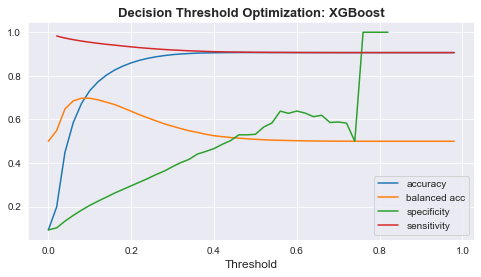

In [45]:
sns.set_style("darkgrid")

# plot lines
plt.figure(figsize=(8,4))
plt.plot(df_results2['threshold'], df_results2['accuracy'], label = "accuracy")
plt.plot(df_results2['threshold'], df_results2['balanced accuracy'], label = "balanced acc")
plt.plot(df_results2['threshold'], df_results2['specificity'], label = "specificity")
plt.plot(df_results2['threshold'], df_results2['sensitivity'], label = "sensitivity")
# # single line
# plt.vlines(x = 0.5, ymin = 0, ymax = 1.0,
#            colors = 'dimgray',
#            linestyle='--')
# plt.vlines(x = 0.85, ymin = 0, ymax = 1.0,
#            colors = 'dimgray',
#            linestyle='--')
plt.legend(loc='lower right')
plt.title('Decision Threshold Optimization: XGBoost', fontsize=13, fontweight='bold')
plt.xlabel('Threshold', fontsize=12)
plt.savefig('charts/models/XGBoost/boost_threshold_balanced.png', bbox_inches='tight')
plt.show()

## TabNet Model

In [58]:
X_train1, X_val1, X_test1, y_train1, y_val1, y_test1 = utilities.process_features(df, 'CVD', QuantileTransformer(output_distribution='uniform'), one_hot=False)
X_train1, y_train1= utilities.resample_data(X_train1, y_train1, 'under')

X_train= X_train1.to_numpy()
X_val= X_val1.to_numpy()
X_test= X_test1.to_numpy()

y_train= y_train1.to_numpy().astype(int)
y_val= y_val1.to_numpy().astype(int)
y_test= y_test1.to_numpy().astype(int)

clf = TabNetClassifier(
    scheduler_fn=torch.optim.lr_scheduler.ReduceLROnPlateau,
    scheduler_params={"mode":'max', # max because default eval metric for binary is AUC
                 "factor":0.1,
                 "patience":1}
)  

# fit model
clf.fit(
    X_train=X_train, y_train=y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    eval_name=['train', 'val'],
    eval_metric=["auc", 'accuracy'],
#     eval_metric=[Recall],

    max_epochs=100 , patience=0,
    batch_size=400,
    virtual_batch_size=128,
    num_workers=0,
    weights=1,
    drop_last=False
) 

Device used : cpu
No early stopping will be performed, last training weights will be used.
epoch 0  | loss: 0.65246 | train_auc: 0.72117 | train_accuracy: 0.66647 | val_auc: 0.72979 | val_accuracy: 0.57466 |  0:00:16s
epoch 1  | loss: 0.60887 | train_auc: 0.74239 | train_accuracy: 0.68823 | val_auc: 0.74817 | val_accuracy: 0.68014 |  0:00:32s
epoch 2  | loss: 0.60288 | train_auc: 0.74417 | train_accuracy: 0.68705 | val_auc: 0.74974 | val_accuracy: 0.64621 |  0:00:48s
epoch 3  | loss: 0.59732 | train_auc: 0.74892 | train_accuracy: 0.69121 | val_auc: 0.75538 | val_accuracy: 0.69157 |  0:01:04s
epoch 4  | loss: 0.59945 | train_auc: 0.75021 | train_accuracy: 0.69102 | val_auc: 0.75815 | val_accuracy: 0.67475 |  0:01:20s
epoch 5  | loss: 0.59741 | train_auc: 0.75121 | train_accuracy: 0.6902  | val_auc: 0.75763 | val_accuracy: 0.71104 |  0:01:36s
epoch 6  | loss: 0.59914 | train_auc: 0.74824 | train_accuracy: 0.6877  | val_auc: 0.75505 | val_accuracy: 0.68012 |  0:01:52s
epoch 7  | loss: 0.5

epoch 64 | loss: 0.58937 | train_auc: 0.75281 | train_accuracy: 0.69387 | val_auc: 0.75932 | val_accuracy: 0.69346 |  0:17:35s
epoch 65 | loss: 0.59104 | train_auc: 0.7529  | train_accuracy: 0.69357 | val_auc: 0.75934 | val_accuracy: 0.69084 |  0:17:54s
epoch 66 | loss: 0.59507 | train_auc: 0.75283 | train_accuracy: 0.69384 | val_auc: 0.75941 | val_accuracy: 0.69347 |  0:18:12s
epoch 67 | loss: 0.59345 | train_auc: 0.75287 | train_accuracy: 0.6935  | val_auc: 0.75932 | val_accuracy: 0.6916  |  0:18:28s
epoch 68 | loss: 0.59171 | train_auc: 0.75285 | train_accuracy: 0.69349 | val_auc: 0.7593  | val_accuracy: 0.69128 |  0:18:43s
epoch 69 | loss: 0.59242 | train_auc: 0.75288 | train_accuracy: 0.69368 | val_auc: 0.75934 | val_accuracy: 0.6916  |  0:19:00s
epoch 70 | loss: 0.5921  | train_auc: 0.75282 | train_accuracy: 0.69373 | val_auc: 0.75929 | val_accuracy: 0.69218 |  0:19:18s
epoch 71 | loss: 0.59079 | train_auc: 0.75285 | train_accuracy: 0.69365 | val_auc: 0.75929 | val_accuracy: 0.69

In [52]:
# loaded_clf = TabNetClassifier()
# loaded_clf.load_model('saved_models/binary_tabnet_model_1.zip')

Device used : cpu
Device used : cpu


In [59]:
y_tabnet_preds = clf.predict_proba(X_test)

In [65]:
y_tabnet_preds

array([[0.60596454, 0.39403543],
       [0.6163614 , 0.38363868],
       [0.66703826, 0.3329617 ],
       ...,
       [0.5151588 , 0.48484123],
       [0.73119426, 0.2688057 ],
       [0.45884317, 0.5411569 ]], dtype=float32)

In [64]:
test_thresholds=np.arange(0,1,0.02)
df_results3 = pd.DataFrame(columns = ['threshold', 'specificity', 'sensitivity', 'accuracy', 'balanced accuracy'])
for threshold in test_thresholds:
    mat, sens,spec, acc, bal = confusion_eval2(y_tabnet_preds[:,1], X_test, y_test, threshold=threshold)
    
    df_new = pd.DataFrame({'threshold':threshold, 'specificity':spec, 'sensitivity':sens, 'accuracy':acc, 'balanced accuracy':bal}, index=[0])
    df_results3 = pd.concat([df_results3,df_new])

[[    0 91183]
 [    0  9314]]
specificity :  0.09267938346418302
sensitivity :  nan
accuracy :  0.09267938346418302
balanced accuracy:  0.5
[[    0 91183]
 [    0  9314]]
specificity :  0.09267938346418302
sensitivity :  nan
accuracy :  0.09267938346418302
balanced accuracy:  0.5
[[    0 91183]
 [    0  9314]]
specificity :  0.09267938346418302
sensitivity :  nan
accuracy :  0.09267938346418302
balanced accuracy:  0.5
[[    0 91183]
 [    0  9314]]
specificity :  0.09267938346418302
sensitivity :  nan
accuracy :  0.09267938346418302
balanced accuracy:  0.5


invalid value encountered in longlong_scalars
invalid value encountered in longlong_scalars
invalid value encountered in longlong_scalars
invalid value encountered in longlong_scalars


[[    0 91183]
 [    0  9314]]
specificity :  0.09267938346418302
sensitivity :  nan
accuracy :  0.09267938346418302
balanced accuracy:  0.5
[[   71 91112]
 [    0  9314]]
specificity :  0.09274490669746878
sensitivity :  1.0
accuracy :  0.093385872215091
balanced accuracy:  0.500389326957876
[[  824 90359]
 [   13  9301]]
specificity :  0.0933273128637367
sensitivity :  0.984468339307049
accuracy :  0.10074927609779397
balanced accuracy:  0.5038205119347534
[[ 3300 87883]
 [   55  9259]]
specificity :  0.09531407630067325
sensitivity :  0.9836065573770492
accuracy :  0.12496890454441426
balanced accuracy:  0.5151429337672289
[[ 6928 84255]
 [  132  9182]]


invalid value encountered in longlong_scalars


specificity :  0.09826942217750997
sensitivity :  0.9813031161473088
accuracy :  0.16030329263560106
balanced accuracy:  0.5309034305876463
[[10898 80285]
 [  228  9086]]
specificity :  0.10166608855221493
sensitivity :  0.9795074600035952
accuracy :  0.19885170701612984
balanced accuracy:  0.547519307042076
[[14720 76463]
 [  319  8995]]
specificity :  0.10525638325259191
sensitivity :  0.9787884832768137
accuracy :  0.2359771933490552
balanced accuracy:  0.5635920418525815
[[19426 71757]
 [  435  8879]]
specificity :  0.11011210873555236
sensitivity :  0.9780977795679976
accuracy :  0.28165019851338846
balanced accuracy:  0.5831701057550192
[[23761 67422]
 [  568  8746]]
specificity :  0.11482512341140637
sensitivity :  0.9766533766287147
accuracy :  0.3234623919121964
balanced accuracy:  0.599801194534473
[[27605 63578]
 [  688  8626]]
specificity :  0.11946706553653537
sensitivity :  0.9756830311384441
accuracy :  0.3605182244246097
balanced accuracy:  0.6144377696463943
[[31129 60

invalid value encountered in longlong_scalars
invalid value encountered in longlong_scalars
invalid value encountered in longlong_scalars
invalid value encountered in longlong_scalars


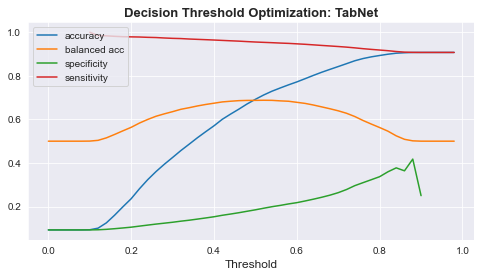

In [67]:
sns.set_style("darkgrid")

# plot lines
plt.figure(figsize=(8,4))
plt.plot(df_results3['threshold'], df_results3['accuracy'], label = "accuracy")
plt.plot(df_results3['threshold'], df_results3['balanced accuracy'], label = "balanced acc")
plt.plot(df_results3['threshold'], df_results3['specificity'], label = "specificity")
plt.plot(df_results3['threshold'], df_results3['sensitivity'], label = "sensitivity")
# # single line
# plt.vlines(x = 0.5, ymin = 0, ymax = 1.0,
#            colors = 'dimgray',
#            linestyle='--')
# plt.vlines(x = 0.85, ymin = 0, ymax = 1.0,
#            colors = 'dimgray',
#            linestyle='--')
plt.legend(loc='upper left')
plt.title('Decision Threshold Optimization: TabNet', fontsize=13, fontweight='bold')
plt.xlabel('Threshold', fontsize=12)
plt.savefig('charts/models/TabNet/tabnet_threshold_balanced.png', bbox_inches='tight')
plt.show()